In [1]:

import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [7]:
def getPortsData(df, origin_port, destination_port_city, destination_port_country):
    # streamline data so it has route and date column
    df['Route'] = df['AustralianPort'] + ' <-> ' + df['ForeignPort'] + ' (' + df['Country'] + ')'
    df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month_num'].astype(str) + '-01')

    # build route string using the provided destination country
    route_str = f"{origin_port} <-> {destination_port_city} ({destination_port_country})"

    route_df = df[df['Route'] == route_str].copy()
    time_series = route_df.set_index('Date')['Passengers_Total'].sort_index()
    return time_series


In [8]:
def runModel(time_series, train_end='1987', test_year='1988',
                        order=(1,1,1), seasonal_order=(1,1,1,12)):

    train = time_series[:train_end]
    test = time_series[test_year]

    model = sm.tsa.statespace.SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    predictions = results.get_prediction(
        start=pd.to_datetime(f'{test_year}-01-01'),
        end=pd.to_datetime(f'{test_year}-12-01'),
        dynamic=False
    )
    pred_mean = predictions.predicted_mean

    monthly_accuracy = {}
    for i, month in enumerate(range(1, 13)):
        actual = test.iloc[i]
        pred = pred_mean.iloc[i]
        monthly_accuracy[month] = 1 - abs(actual - pred) / actual

    print(f"Monthly standardized accuracy for {test_year}:")
    for month, acc in monthly_accuracy.items():
        print(f"Month {month:02d}: Accuracy ≈ {acc:.4f}")

    ax = time_series.plot(label='Observed', figsize=(12, 6))
    pred_mean.plot(ax=ax, label='Forecast', alpha=0.7)
    ax.set_xlabel('Date')
    ax.set_ylabel('Passenger Traffic')
    plt.title(f'SARIMA Forecast vs Observed Data ({time_series.name})')
    plt.legend()
    plt.ylim(bottom=0)
    plt.show()

    return monthly_accuracy

Monthly standardized accuracy for 1988:
Month 01: Accuracy ≈ 0.9935
Month 02: Accuracy ≈ 0.9012
Month 03: Accuracy ≈ 0.9752
Month 04: Accuracy ≈ 0.9199
Month 05: Accuracy ≈ 0.9625
Month 06: Accuracy ≈ 0.9923
Month 07: Accuracy ≈ 0.9641
Month 08: Accuracy ≈ 0.8988
Month 09: Accuracy ≈ 0.9507
Month 10: Accuracy ≈ 0.8767
Month 11: Accuracy ≈ 0.8053
Month 12: Accuracy ≈ 0.8905


/Users/arjunsikka/PycharmProjects/data-tech-challenge/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/arjunsikka/PycharmProjects/data-tech-challenge/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/arjunsikka/PycharmProjects/data-tech-challenge/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


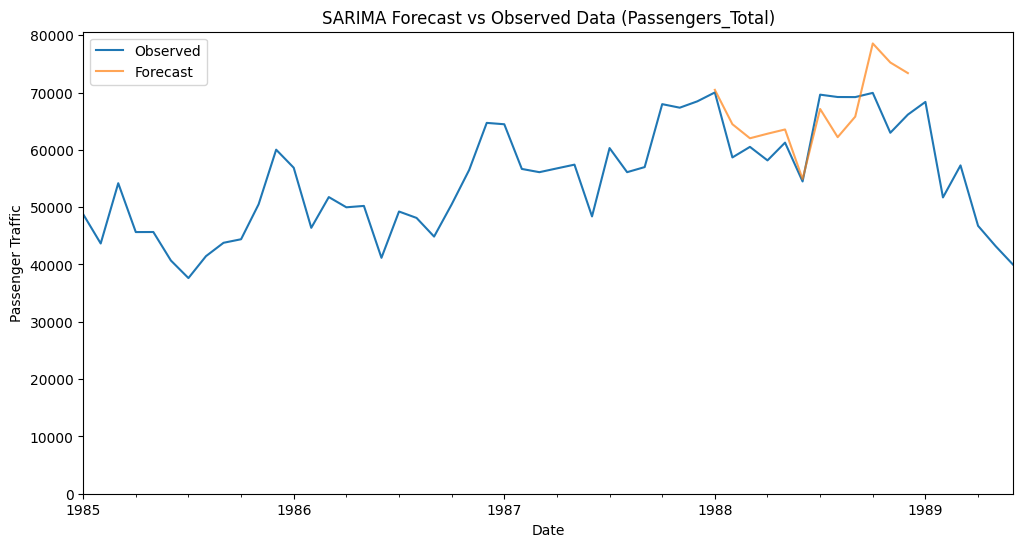

In [14]:
df = pd.read_csv('data/AeroConnectData.csv')

ts = getPortsData(df, 'Sydney', 'Auckland', 'New Zealand')

monthly_acc = runModel(ts)
